# Detecting bullying Tweets with PyTorch Bidirectional LSTM and BERT Transformer Project

This project is about the analysis of tweets about cyberbullying, with the goal of performing a Sentiment Analysis using Bidirectional LSTM and BERT on PyTorch to predict if a tweet is about cyberbullying or not. <br>
In particular, bullying tweets are divided in 4 categories: religion, age, race and gender.<br>
The project is divided in the following sections:
- Data Import
- Text cleaning with custom defined functions
- Naive Bayes baseline model Classifier
- Data preparation for LSTM RNN: Tokenization
- PyTorch LSTM RNN Classifier
- Data preparation for BERT: Tokenization
- PyTorch BERT Classifier
- Results summary

# Main results summary:

<img src="https://i.imgur.com/TU74srO.png">

<img src="https://i.imgur.com/sgQVKxv.png">

**Naive Bayes baseline classifier performed quite well on the dataset, with an overall accuracy of 85% among all the classes.<br>
On the other hand, the custom Bidirectional LSTM RNN by PyTorch achieved an accuracy of 94%, where some classes have F1 score over 95%.**<br>
**Finally, BERT performed the best, with an overall accuracy around 95% and F1 scores over 96%.**<br>
Overall, the algorithms could properly distinguish the different topics of the bullying tweets, and had little **more troubles** with the **less populated class "not cyberbullying" and the "gender" class (achieving lower precision and recall compared to other classes)**.<br>
For this reason, it could be a good idea to **collect more data of this classes** and aim to achieve higher accuracy and F1 score.

This code recursively lists all files and directories within the current directory and its subdirectories, printing the full path of each file.





In [1]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data.csv
./.config/config_sentinel
./.config/.last_update_check.json
./.config/.last_opt_in_prompt.yaml
./.config/.last_survey_prompt.yaml
./.config/active_config
./.config/gce
./.config/logs/2023.04.13/13.28.53.665788.log
./.config/logs/2023.04.13/13.30.17.294219.log
./.config/logs/2023.04.13/13.29.19.483680.log
./.config/logs/2023.04.13/13.29.51.584180.log
./.config/logs/2023.04.13/13.30.16.508499.log
./.config/logs/2023.04.13/13.29.43.381288.log
./.config/configurations/config_default
./sample_data/README.md
./sample_data/anscombe.json
./sample_data/mnist_train_small.csv
./sample_data/mnist_test.csv
./sample_data/california_housing_train.csv
./sample_data/california_housing_test.csv


## Custom functions definition:

This code defines a function conf_matrix() that creates a heatmap of a confusion matrix, given the true labels y and predicted labels y_pred, as well as a title and labels for the axes. The function uses the seaborn library to create the heatmap, and allows customization of the font sizes and color map.





In [2]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

## Import libraries

install package

In [3]:
!pip install demoji
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.9 MB/s eta 0:00:00


import libraries

In [4]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import demoji
import nltk

from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

#Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-4-b7c7bdcb6d9f>:60: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

## Data Import

read data frome csv file

In [5]:
df = pd.read_csv("data.csv")

print the first 5 rows

In [6]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


print data frame infor

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


First we rename the columns using shorter words for easier reference.

In [8]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

### Are there duplicated tweets?

count the number of duplicates row

In [9]:
df.duplicated().sum()

36

There are some duplicated tweets, we will remove them.

remove duplicates row

In [10]:
df = df[~df.duplicated()]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### Are the classes balanced?

count the number of unique values in each columns

In [12]:
df.sentiment.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: sentiment, dtype: int64

The classes look balanced.

# Tweets text deep cleaning

Next, we will define custom functions to clean the texts of the tweets.

The code provides custom-defined functions to clean tweets, including stripping emojis, removing punctuations, links, stopwords, mentions and new line characters, decontracting contractions, cleaning hashtags, filtering special characters, removing multiple sequential spaces, stemming and lemmatization. Finally, the defined functions are applied in a specific order to deep clean the text.





In [13]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '') #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

The code applies the function deep_clean() to the text column of a pandas dataframe, which includes several custom-defined cleaning operations such as removing emojis, punctuation, stop words, and contractions, stemming, and lemmatization, with the aim of standardizing the text data. The cleaned text is stored in a new list texts_new.





In [15]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))

create new column text_clean

In [16]:
df['text_clean'] = texts_new

In [17]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...


### Are there duplicate tweets after the cleaning?

print the shape of dataframe

In [18]:
df.shape

(47656, 3)

count the number of duplicates rows in text_clean column

In [19]:
df["text_clean"].duplicated().sum()

3058

There are around 3000 duplicated tweets, we will remove them.

remove the duplicates rows in text_clean column

In [20]:
df.drop_duplicates("text_clean", inplace=True)

print the shape of data frame

In [21]:
df.shape

(44598, 3)

We removed the duplicated cleaned tweets. How is the class balance after the cleaning?

count the number of unique values in sentiment column

In [22]:
df.sentiment.value_counts()

religion               7946
age                    7884
ethnicity              7744
not_cyberbullying      7637
gender                 7607
other_cyberbullying    5780
Name: sentiment, dtype: int64

We can see that lots of tweets of the class "other_cyberbullying" have been removed. Since the class is very unbalanced compared to the other classes and looks too "generic", we decide to remove the tweets labeled belonging to this class.<br>
EDIT: by performing some tests, the f1 score for predicting the "other_cyberbullying" resulted to be around 60%, a value far lower compared to the othter f1 scores (around 95% using LSTM model). This supports the decision of removing this generic class.

This code removes all the rows from a pandas DataFrame where the value in the "sentiment" column is equal to "other_cyberbullying".





In [23]:
df = df[df["sentiment"]!="other_cyberbullying"]

Then we also define a list of the classes names, which will be useful for the future plots.

define sentiments variable

In [24]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

This code is creating a list text_len that contains the number of words in each tweet in the cleaned dataset df.text_clean.





In [25]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [26]:
df['text_len'] = text_len

This code generates a bar plot using seaborn library to display the count of tweets with less than 10 words in the text. It also removes the y-axis labels and adds count labels to the top of each bar.





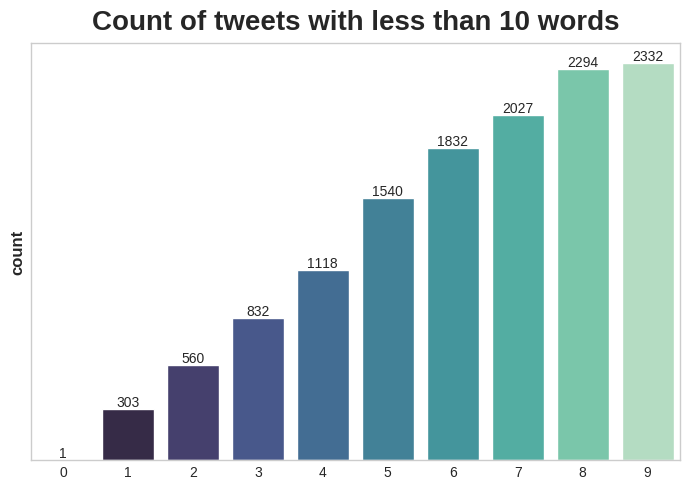

In [27]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We will remove tweets that are too short (less than 4 words).

filter dataframe with text_len > 3

In [28]:
df = df[df['text_len'] > 3]

### What about long tweets?

sort the dataframe values by text_len


In [29]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white tri live like nigger pahahahaha co...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb ass nigger bitch ltthi whore s...,162
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilti kill feel guilti enjoy torment sin...,137
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,research push import top antibulli program us ...,137
47037,@Purely_Ambition: Sooo mad. RT @TracePeterson ...,ethnicity,sooo mad rt fuck obama dumb nigger go switzerl...,125
...,...,...,...,...
10274,@holliebakerlutz What does that 23% figure rep...,gender,23 figur repres deriv,4
5229,are bully sticks for dogs safe,not_cyberbullying,bulli stick dog safe,4
10314,RT @Mr_LayedBak: I'm not sexist... but women r...,gender,rt sexist women ref,4
5237,*hands you a bag of trail mix*,not_cyberbullying,hand bag trail mix,4


This code creates a bar plot using Seaborn library to show the count of tweets with high number of words (between 10 and 1000 words). The plot has a title, y-axis label ('count'), and x-axis with no label. The plot uses the 'Blues_r' color palette and the count labels are added to the top of each bar.





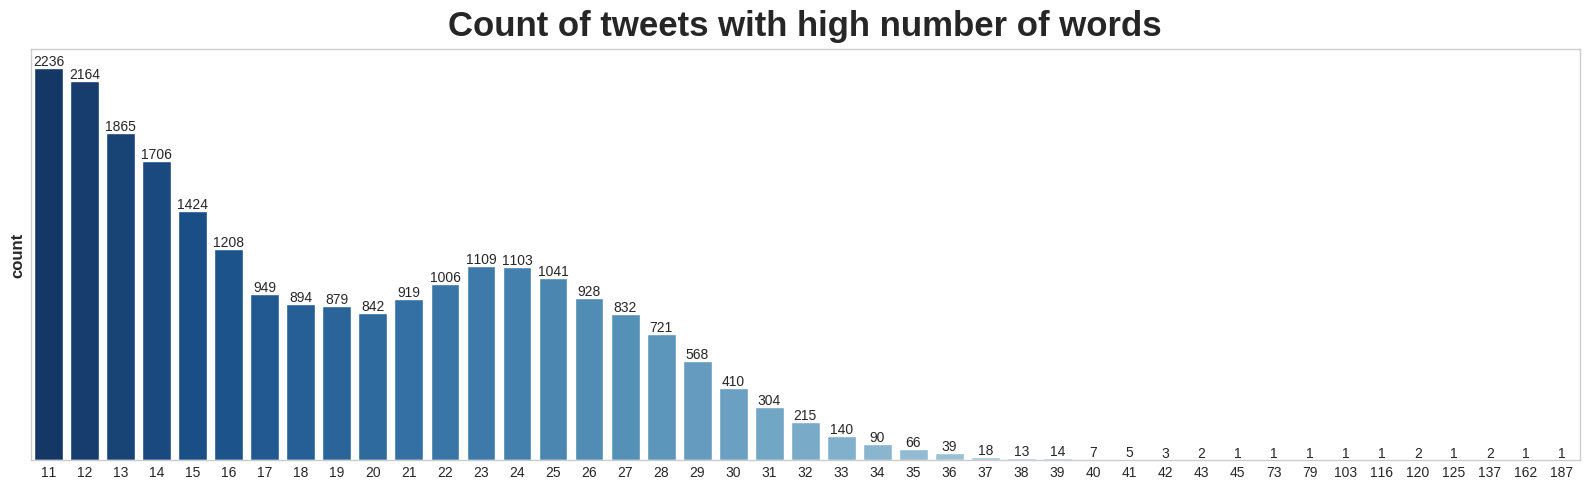

In [30]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

filter dataframe with text_len < 100

In [31]:
df = df[df['text_len'] < 100]

Then we also get the length of the longest tweet since it will be useful later.

get the max value of text_lent

In [32]:
max_len = np.max(df['text_len'])
max_len 

79

sort the dataframe by text_len

In [33]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
4846,@andrea_gcav: @viviaanajim recuerdas como noso...,not_cyberbullying,recuerda como nosotra tambin eramo victima del...,79
44294,@JasmineLovvee If He Dont Want You Well Fuck H...,ethnicity,dont want well fuck aint worth tear never swea...,73
45930,"Get off ur ego trip, take off ur rose colored ...",ethnicity,get ur ego trip take ur rose color glass amp g...,45
21241,And yet God was able to meet their needs using...,religion,yet god abl meet need use radic everyday gener...,43
41749,@seijohgorl hoy mami keito AAAA okay so um ika...,ethnicity,hoy mami keito aaaa okay um ikaw talaga one fi...,43
...,...,...,...,...
44750,What the fuck you dumb nigger I hate you now,ethnicity,fuck dumb nigger hate,4
1673,@UMTony lmao! I really wanted to take it down!,not_cyberbullying,lmao realli want take,4
35335,He's a grade school bully. He's a coward!,age,grade school bulli coward,4
3920,Need to let my anger out dude.,not_cyberbullying,need let anger dude,4


## Sentiment column encoding

The target column will be encoded by ordinal encoding

This code replaces the values of the 'sentiment' column in a Pandas dataframe with numerical values. The original values are replaced with the corresponding numerical value: 'religion' is replaced with 0, 'age' with 1, 'ethnicity' with 2, 'gender' with 3, and 'not_cyberbullying' with 4.

In [34]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

## Train - Test split

Now we need to split the dataset into a train and test sets.

This code creates two variables, X and y, by assigning the preprocessed texts (text_clean) to X and the corresponding sentiment labels to y. This is typically done to prepare the data for machine learning tasks such as sentiment analysis, where X would be the input features and y the target variable.





In [35]:
X = df['text_clean']
y = df['sentiment']

This code splits the dataset into training and testing sets, where X represents the text features and y represents the target sentiment labels. The split is performed using the train_test_split function from the sklearn.model_selection module, with a test size of 0.2 (20% of the data), stratified sampling based on y, and a specified random seed value. The resulting splits are stored in the variables X_train, X_test, y_train, and y_test.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monior the accuracy and loss to avoid overfitting during the model training.

This code is splitting the training data further into a validation set and a new training set. The new training set will be 90% of the original training set, while the validation set will be 10% of the original training set. The train_test_split function is used again to achieve this, with the new training set being assigned to X_train and y_train, and the validation set being assigned to X_valid and y_valid.





In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

This code counts the number of occurrences of each unique element in the y_train array and creates a 2D numpy array that contains the unique elements and their corresponding counts. The resulting array has two columns: the first column contains the unique elements and the second column contains their corresponding counts.





In [38]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5638],
       [   2, 5549],
       [   3, 5264],
       [   4, 4587]])

The classes are unbalanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one.

# Oversampling of training set

The code performs oversampling of the minority class using RandomOverSampler from the imblearn library to balance the training set. It resamples the training data X_train and y_train, and creates a new DataFrame called train_os containing the oversampled data.





In [39]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

This code assigns the 'text_clean' column of a DataFrame to the variable X_train and the 'sentiment' column to the variable y_train. The values attribute is used to convert them into numpy arrays.





In [40]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

This code calculates the unique values and their counts in the y_train array, and then returns them as a NumPy array where the unique values and their counts are paired together.





In [41]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

# Naive Bayes baseline model

The first algorithm we will implement is Naive Bayes, which will be used as a simple baseline model. In order to use this algorithm, we need first need to preprocess the text data. <br>
First, we will create a bag of words using CountVectorizer.

This code initializes a CountVectorizer and uses it to transform the training and test data sets into matrices of token counts. The fit_transform method is called on the CountVectorizer object with the training data as input to learn the vocabulary and encode the data, and transform is called with the test data as input to transform it into a matrix of token counts using the learned vocabulary. The resulting transformed data sets are stored in X_train_cv and X_test_cv, respectively.





In [42]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Then we apply TF-IFD transformation to associate weigths to the different words based on their frequency (rarer words will be given more importance).

write the short abstract to sumarries this code:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [43]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Finally we can instantiate the Naive Bayes model.

This code line creates an instance of the Multinomial Naive Bayes classifier and assigns it to the variable 'nb_clf'.





In [44]:
nb_clf = MultinomialNB()

This code fits a Multinomial Naive Bayes classifier to the training data (X_train_tf) and corresponding labels (y_train).





In [45]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

This code performs prediction using the trained Naive Bayes classifier nb_clf on the test set X_test_tf and stores the predicted labels in the variable nb_pred.





In [46]:
nb_pred = nb_clf.predict(X_test_tf)

print the classification report

In [47]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.85      0.97      0.91      1579
         age       0.80      0.98      0.88      1566
   ethnicity       0.90      0.92      0.91      1542
      gender       0.89      0.85      0.87      1462
not bullying       0.84      0.47      0.60      1274

    accuracy                           0.85      7423
   macro avg       0.86      0.84      0.84      7423
weighted avg       0.86      0.85      0.84      7423



print the confusion matrix

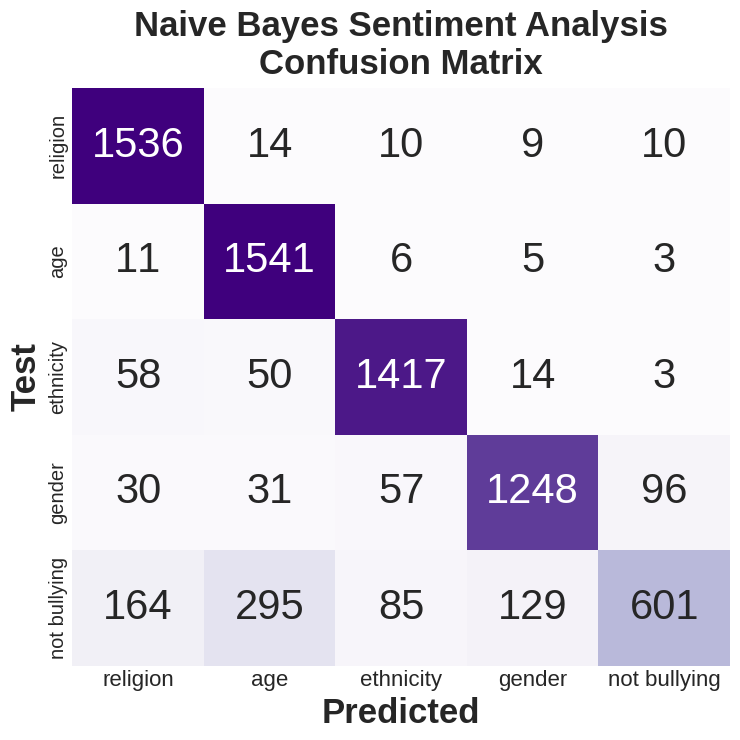

In [48]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of the algorithm is very good, with an overall accurcy of 85%.<br>
We can observe how the predictions for the more populated classes have very high F1 scores (over 85%), while for the class "non-cyberbullying" the score is much lower.**

*Next we will implement a more complex algorithm to perform the classification, aiming to achieve higher accurcy than the baseline Naive Bayes model.*

# PyTorch Bi-LSTM RNN

In this section, we will define a custom Bidirectional LSTM using PyTorch in order to perform the Sentiment Analysis on the tweets.

# Data preprocessing for LSTM

Similarly to what we did with Naive Bayes, we need to preprocess the data: in particular we will tokenize the sentences with a custom defined function. <br>
The sentences will be converted to lists of number with padding to the max number of words in a sentence.

The code is a function called "Tokenize" that takes a column of text data and a specified sequence length as inputs. The function first creates a vocabulary of words from the column, and then uses this vocabulary to tokenize the text data. The resulting tokenized data is then padded with zeros to ensure a consistent sequence length. Finally, the function returns the sorted vocabulary and the padded tokenized data.





In [49]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

The code uses a function called "Tokenize" to preprocess a column of text data ("text_clean") in a Pandas DataFrame ("df") and tokenize it into numerical values. The resulting tokenized data is stored in a variable called "tokenized_column," and the corresponding vocabulary used for the tokenization is stored in a variable called "vocabulary." The maximum length of the tokenized sequence is specified by the variable "max_len."





In [50]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

We can check how each tweet has been tokenized with an example:

In [51]:
df["text_clean"].iloc[10]

'love best respons hotcak manag film noncommitt meh adolesc mkr'

This sentence is transformed to the vector:

In [52]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,    66,   219,   503,
        8001,  1300,  1142, 13587,  4686,  9804,    34])

Moreover we can also check the TOP 20 most common words by extracting them from the vocabulary python dictionary we created with the tokenizer.

The code extracts the first 20 key-value pairs from a pre-existing vocabulary dictionary and stores the keys in a list called "keys" and the values in a list called "values". The purpose of this code is likely to visualize or analyze the most frequent words in the vocabulary by only looking at the top 20.





In [53]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

This code creates a bar plot using Seaborn library to display the 20 most common words in a given vocabulary. The plot's x-axis shows the word's text, and the y-axis shows the frequency of the word's occurrence. The plot is labeled with a title indicating the top 20 most common words, and the y-axis is labeled with "Words count." Finally, the plot is displayed using the "plt.show()" command.





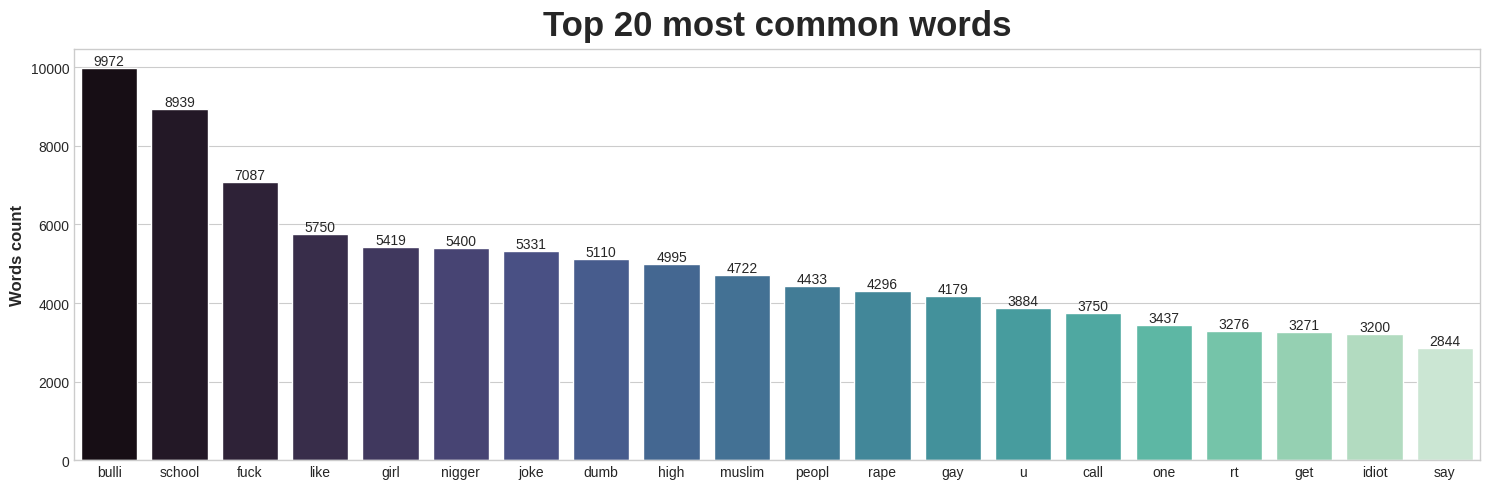

In [54]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

# Word Embedding by Word2Vec

Next, we will create a word embedding matrix using the original text tweets and the pre trained model Word2vec.<br>
First, we create a list of words from the X_train vector created before.

This code is taking a list of text data called "X_train" and is splitting each piece of text into separate words. The resulting output is a list of lists where each sublist contains the individual words of each original text in "X_train." This output is assigned to a new variable called "Word2vec_train_data," which can be used as input for training a word embedding model using the Word2Vec algorithm.





In [55]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

We set a dimension of the embedding words, which can be seen as the number of featurs of each transformed word.

In [56]:
EMBEDDING_DIM = 200

Then we can instaniate the Word2Vec model by passing the training words and chosen embedding dimension to the imported Word2vec object.

This code trains a Word2Vec model using the "Word2vec_train_data" list of lists as input. The resulting trained model is stored in a variable called "word2vec_model." The "vector_size" parameter is set to specify the number of dimensions for the resulting word embedding vectors. The size of the vector is controlled by the variable "EMBEDDING_DIM."





In [57]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

Before defining the embedding matrix, we also need to choose the max number of words. We will extract the number of words from the vocabulary python dictionary we created before.

print the vocabulary size

In [58]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 33009


In [59]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Finally we can define the embedding matrix.

This code initializes an empty numpy array called "embedding_matrix" with dimensions (VOCAB_SIZE, EMBEDDING_DIM), where "VOCAB_SIZE" represents the size of the vocabulary and "EMBEDDING_DIM" represents the dimension of the word embeddings. The code then fills the embedding matrix with pre-trained values from a Word2Vec model ("word2vec_model") corresponding to each word in the vocabulary ("vocabulary") by checking if the Word2Vec model contains that word. If so, the corresponding embedding vector is retrieved from the Word2Vec model and added to the embedding matrix at the position corresponding to the token assigned to that word in the vocabulary. Finally, the shape of the embedding matrix is printed for verification purposes.





In [60]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (33009, 200)


## Train - Validation - Test split

Now we will use the tokenized sentences to create a training, validation and test datasets.

This code assigns the tokenized text data in the variable "tokenized_column" to a new variable called "X". It also assigns the values in the "sentiment" column of a Pandas DataFrame "df" to a numpy array called "y." These variables "X" and "y" are typically used as input for training a machine learning model for sentiment analysis or classification.





In [61]:
X = tokenized_column
y = df['sentiment'].values

This code uses the "train_test_split" function from the scikit-learn library to split the input data (in this case, "X" and "y") into training and testing sets. The training data is assigned to variables "X_train" and "y_train," while the testing data is assigned to variables "X_test" and "y_test." The "test_size" parameter is set to specify the percentage of data to use for testing (in this case, 20% of the data), and the "stratify" parameter is set to ensure that the proportion of each class in the original data is maintained in both the training and testing sets. The "random_state" parameter is set to ensure reproducibility of the results.





In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

This code further splits the training data ("X_train" and "y_train") into training and validation sets, with the training data now assigned to variables "X_train" and "y_train," and the validation data assigned to variables "X_valid" and "y_valid." The "test_size" parameter is set to specify the percentage of the training data to use for validation (in this case, 10% of the training data), and the "stratify" parameter is set to ensure that the proportion of each class in the original training data is maintained in both the training and validation sets. The "random_state" parameter is set to ensure reproducibility of the results. This step is typically done to evaluate the performance of the model on a hold-out set before testing it on the completely unseen test data.





In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

We can check the balance of the target classes:

This code uses NumPy to calculate the frequency of each class label in the "y_train" array, which represents the sentiment labels for the training data. The "np.unique" function returns the unique values in the array ("unique") and their corresponding counts ("counts"). The "np.asarray" function is used to combine the "unique" and "counts" arrays into a single NumPy array with each row consisting of a unique label and its count. The ".T" method is used to transpose the array so that each row displays the label and count as columns instead of rows. This is useful for visualizing the class distribution of the training data.





In [64]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5638],
       [   2, 5549],
       [   3, 5264],
       [   4, 4587]])

And then apply random oversampling on the training set.

This code uses the "RandomOverSampler" method from the "imblearn" library to oversample the minority class in the training data. Specifically, it generates new samples for the minority class (i.e. the less frequently occurring class) until the class distribution is balanced. The "fit_resample" function is then used to fit the oversampler to the data and transform it by generating new samples. The resulting oversampled training data is stored in "X_train_os" and "y_train_os".





In [65]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

This code calculates the class distribution in the oversampled training data. It first uses the "unique" function to obtain the unique class labels and their frequency counts in "y_train_os". It then creates an array with two columns, where the first column contains the unique class labels and the second column contains the frequency counts. The resulting array is stored in "np.asarray((unique, counts)).T".





In [66]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

## PyTorch datasets and dataloaders

The three sets will be transformed to tensor datasets and dataloaders so we can extract the data in batches for the LSTM training, validation and testing.

This code creates PyTorch TensorDataset objects for the training, testing, and validation data. The X_train_os and y_train_os arrays are converted to PyTorch tensors using torch.from_numpy() and combined into a single TensorDataset object using TensorDataset(). The same is done for X_test and y_test to create the test_data object and for X_valid and y_valid to create the valid_data object.





In [67]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [68]:
BATCH_SIZE = 32

This code is creating three data loaders, one for training data, one for validation data, and one for test data. The data is loaded in batches using the DataLoader class from PyTorch, and each batch will have a size of BATCH_SIZE. The shuffle parameter is set to True so that the data is shuffled before being loaded, and drop_last is set to True to drop the last batch if it's smaller than the specified batch size.





In [69]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

# PyTorch LSTM modeling

Finally we can start the LSTM modeling. We start by setting some hyperparameters.

In [70]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 5 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

This code defines a class BiLSTM_Sentiment_Classifier which inherits from the nn.Module class of PyTorch. The class has an initializer method that takes in several parameters including vocabulary size, embedding dimension, hidden dimension, number of classes, number of LSTM layers, boolean value indicating whether the LSTM is bidirectional, batch size, and dropout rate. The class also has a forward method that takes in an input tensor x and a hidden state hidden. The forward method performs several operations including embedding the input tensor, passing it through the LSTM layers, extracting the last hidden state, passing it through a fully connected layer, and returning the output along with the hidden state. The class also has an init_hidden method that initializes the LSTM hidden and cell states.





In [71]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

This code defines a BiLSTM sentiment classifier model using PyTorch's nn.Module. The constructor initializes the model's layers, including embedding, LSTM, fully connected, and softmax layers. The forward method takes the input, runs it through the layers, and returns the output along with the hidden state. The init_hidden method initializes the hidden and cell states of the LSTM. Finally, the model is instantiated, the embedding is initialized with the pre-trained embedding matrix, and the requires_grad attribute of the embedding matrix is set to True to fine-tune it. The model is then printed.





In [72]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(33009, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


This code initializes the loss function as negative log likelihood loss (NLLLoss) and the optimizer as AdamW with a specified learning rate and weight decay value. The optimizer will be used to update the parameters of the model during training.





In [73]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

# LSTM Training loop 

Now we will define a custom training loop, where we include an early stopping functionality, and save only the best models in terms of validation accuracy.

This code trains a Bidirectional LSTM model to perform sentiment analysis on text data. The training and validation datasets are loaded using PyTorch DataLoader. The training process is done in epochs. In each epoch, the model is trained on batches of the training data and the validation accuracy is calculated on batches of the validation data. The model is saved if the validation accuracy improves in the current epoch. Early stopping is implemented if there is no improvement in the validation accuracy over a specified number of epochs. The optimizer used is AdamW and the loss function used is negative log likelihood loss. The training process outputs the training and validation loss and accuracy for each epoch.





In [74]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 91.949728).  Saving model ...
	Train_loss : 0.6733 Val_loss : 0.2401
	Train_acc : 74.024% Val_acc : 91.950%
Epoch 2:Validation accuracy increased (91.949728 --> 92.663043).  Saving model ...
	Train_loss : 0.1796 Val_loss : 0.1965
	Train_acc : 94.109% Val_acc : 92.663%
Epoch 3:Validation accuracy increased (92.663043 --> 92.934783).  Saving model ...
	Train_loss : 0.1136 Val_loss : 0.1994
	Train_acc : 96.234% Val_acc : 92.935%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0737 Val_loss : 0.2265
	Train_acc : 97.706% Val_acc : 92.120%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0518 Val_loss : 0.2500
	Train_acc : 98.432% Val_acc : 91.950%


save model

In [75]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

# LSTM Testing

test LSTM model

In [76]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

print the classification report

In [77]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.95      0.94      0.95      1572
         age       0.97      0.98      0.98      1560
   ethnicity       0.98      0.98      0.98      1535
      gender       0.96      0.86      0.91      1456
not bullying       0.79      0.88      0.84      1269

    accuracy                           0.93      7392
   macro avg       0.93      0.93      0.93      7392
weighted avg       0.94      0.93      0.93      7392



print the confusion matrix

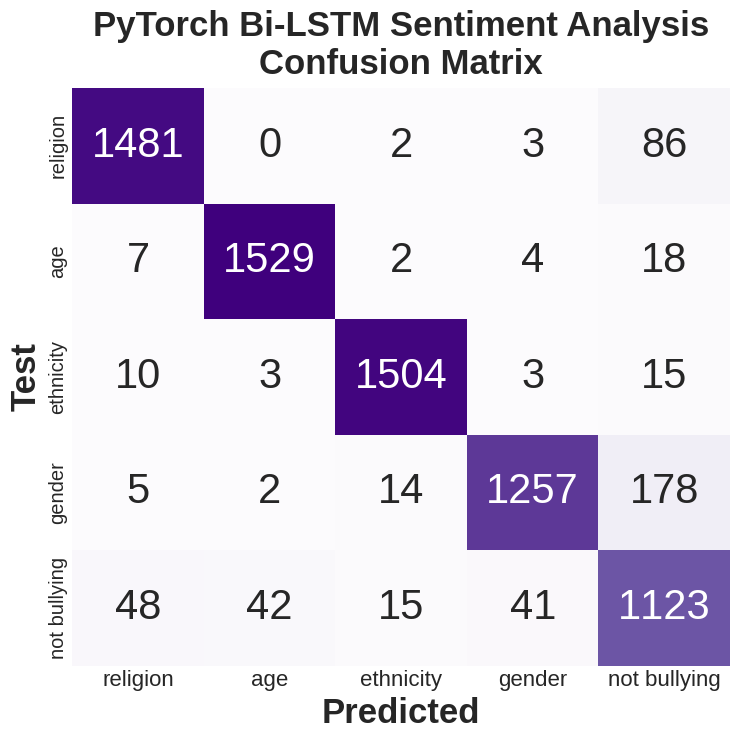

In [78]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of the algorithm are very high, with an overall accuracy of 94%.**<br>
**In particular, the F1 scores for the more populated classes are over 95%**

# BERT Classification

In this section, we will load a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

First, we need to split the dataset into train - validation - test again since we need to tokenize the sentences differently from before (Naive Bayes and LSTM).

## Train - Validation - Test split

Define the X, y

In [79]:
X = df['text_clean'].values
y = df['sentiment'].values

split X_train, X_test, y_train, y_test

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

split X_train, X_valid, y_train, y_valid

In [81]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

As seen before, we oversample the text to the majority class.

The code is performing oversampling on the training data using the RandomOverSampler class from the imbalanced-learn library. It reshapes the input data and target labels into arrays and then applies the fit_resample method to oversample the minority class in the target labels to balance the classes in the training data. The oversampled data is then saved to X_train_os and y_train_os.





In [82]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

This code flattens the oversampled training data arrays X_train_os and y_train_os to one-dimensional arrays.





In [83]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

This code computes the frequency distribution of classes in the oversampled training data. It uses NumPy's unique function to get an array of unique classes and their counts, and then returns a 2D array of class and count pairs.

In [84]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

# BERT Tokenization

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

load Bert Tokenizer from pretrained

In [85]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Then we define a custom tokenizer function using the loaded tokenizer.

The function bert_tokenizer tokenizes input data using the BERT tokenizer. The function iterates through each sentence in the data, and uses the encode_plus method from the tokenizer to encode the sentence as a list of input IDs and an attention mask. The function then returns the input IDs and attention masks as PyTorch tensors. The MAX_LEN parameter is used to truncate or pad sentences to a fixed length.





In [86]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the longest sentence.

The code tokenizes the training tweets using the tokenizer object and finds the length of the longest tokenized tweet.





In [87]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  126


We can choose the max length as 128.

In [88]:
MAX_LEN = 128

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

This code tokenizes the training, validation, and test data using a BERT tokenizer function called bert_tokenizer(). The function returns tokenized input data and attention masks for the BERT model. The training data is oversampled using a RandomOverSampler to balance the data. The tokenization process converts the input text into token IDs and creates an attention mask indicating which tokens are part of the input sentence and which are padding tokens.





In [89]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

This code converts the target labels to PyTorch tensor format for the training, validation, and test sets.

In [90]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.

In [91]:
batch_size = 32

This code creates data loaders for the training, validation, and test sets, each with corresponding tensors containing input IDs, attention masks, and labels. It uses PyTorch's TensorDataset to create the dataset, RandomSampler and SequentialSampler for shuffling the data, and DataLoader to combine the dataset and sampler to generate batches of data.





In [92]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

This code defines a PyTorch neural network model called "Bert_Classifier" which is a classifier model based on the pre-trained BERT language model. The model has three layers: an input layer with 768 neurons, a hidden layer with 50 neurons and a final output layer with 5 neurons for 5 different sentiment labels. The model uses the pre-trained BERT model, which is loaded from the 'bert-base-uncased' checkpoint. The forward() method of the model accepts input_ids and attention_mask as input and returns the predicted logits. If specified, the BERT model parameters can be frozen to avoid fine-tuning.





In [93]:
%%time
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Add dense layers to perform the classification
        self.classifier = nn.Sequential(
            nn.Linear(n_input,  n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )
        # Add possibility to freeze the BERT model
        # to avoid fine tuning BERT params (usually leads to worse results)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input data to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 36 µs, sys: 1 µs, total: 37 µs
Wall time: 43.6 µs


Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

This code defines a function initialize_model() which initializes a BERT classifier with the Bert_Classifier class defined earlier. The function takes the number of epochs as an argument, and sets up the optimizer and learning rate scheduler for the model. The BERT classifier is moved to the device (CPU or GPU) specified earlier. Finally, the function returns the initialized model, optimizer, and scheduler.





In [94]:
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)
    
    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )
    
    ### Set up learning rate scheduler ###

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Defint the scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

check device is gpu or cpu

In [95]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [96]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

# BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

This code defines a function bert_train that trains a BERT classifier model. It takes in the model object, train_dataloader object, val_dataloader object (optional), number of epochs (default=4) and a evaluation boolean flag (default=False). The function starts by defining a loss function (CrossEntropyLoss) for multi-class classification task. It then loops through each epoch and batches of data. For each batch, it sets the model in training mode, performs a forward pass through the model, computes the loss and gradients, clips the gradients, updates the model parameters, and tracks the training time and loss. After each epoch, it switches the model to evaluation mode and evaluates the model's performance on the validation data (if provided). It tracks the validation accuracy and loss. Finally, it prints the average training loss and the validation accuracy and loss for each epoch.





In [97]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

start training

In [98]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.689470   |   57.55  
   200    |   0.276963   |   59.06  
   300    |   0.239923   |   60.22  
   400    |   0.229640   |   60.83  
   500    |   0.227868   |   61.66  
   600    |   0.212663   |   61.53  
   700    |   0.210431   |   61.66  
   800    |   0.198529   |   61.86  
   887    |   0.194242   |   53.82  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.277181    |  0.178395  |       94.06       |  558.39  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.138786   |   62.91  
   2

# BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

define bert prediction function 

In [99]:
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

predict with bert model

In [100]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

print the classification report

In [101]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.96      0.96      0.96      1579
         age       0.98      0.98      0.98      1566
   ethnicity       0.99      0.99      0.99      1542
      gender       0.92      0.91      0.92      1462
not bullying       0.84      0.85      0.85      1274

    accuracy                           0.94      7423
   macro avg       0.94      0.94      0.94      7423
weighted avg       0.94      0.94      0.94      7423



print the confusion matrix

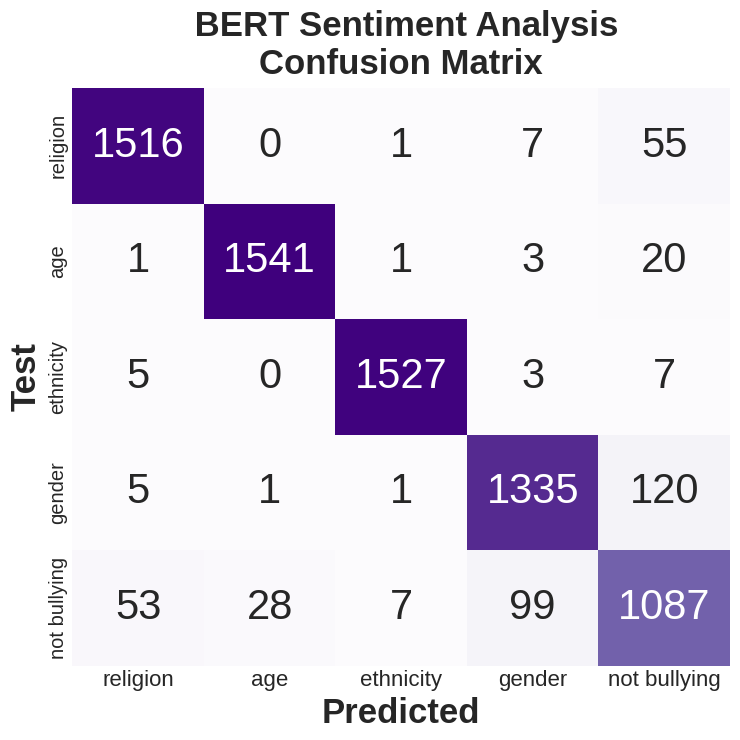

In [102]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of BERT Classifier are quite high and higher than those achieved using the LSTM model, with an overall accuracy around 95% and F1 scores well over 95%.**<br>